## Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [65]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

In [97]:
import seaborn as sns
import numpy as np

In [4]:
df = pd.read_csv('./data/sentiment.csv')

### Checking for Nulls

In [6]:
df.isna().sum()

neg           0
neu           0
pos           0
compound      0
selftext    447
target        0
dtype: int64

In [8]:
df.dropna(inplace = True)

There aren't many nulls in comparison to the total size of the dataframe so I will drop the null values from the set.

### Removing any web addresses from text

In [9]:
df['selftext'] = df['selftext'].replace('http\S+', '', regex=True).replace('www\S+', '', regex=True).replace('#\S+', '', regex=True).replace('\n\n\S+', '', regex=True)

In [10]:
X = df[['selftext', 'compound', 'neg', 'neu', 'pos']]
y = df['target']

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 12, stratify = y)

### Baseline

In [12]:
y_train.mean(), y_test.mean()

(0.49114331723027377, 0.49122524553212044)

The baseline model accuracy score is roughly 50%. This was guaranteed when the data was combined in the first notebook by having the same number of documents from each subreddit.

For future model evaluation I will check that the accuracy score is above 50%, however, I will focus on optimizing for **recall**. The reason for this is if a future investor's risk was classified as 0, r/investing but was placed in 1, r/wallstreetbets they wouldn't be comfortable with the level of stress with the increased volatility.

### TFIDF

In [15]:
tvec = TfidfVectorizer(stop_words = 'english', max_features = 3000)

X_train_tvec = tvec.fit_transform(X_train['selftext'])
X_test_tvec = tvec.transform(X_test['selftext'])

In [16]:
df_X_train = pd.DataFrame(X_train_tvec.todense(), columns=tvec.get_feature_names())

df_X_test = pd.DataFrame(X_test_tvec.todense(), columns = tvec.get_feature_names())

In [17]:
df_X_train.reset_index(drop=True, inplace=True)
X_train.reset_index(drop=True, inplace=True)
df_X_test.reset_index(drop=True, inplace = True)
X_test.reset_index(drop=True, inplace=True)

In [18]:
X_train_all = pd.concat([df_X_train, X_train], axis =1)
X_train_all.head(1)

,00,000,01,02,03,04,05,06,07,08,...,ytd,zero,zillow,zm,zoom,selftext,compound,neg,neu,pos
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,He says no recession which I think means buy p...,-0.6124,0.417,0.583,0.0


In [19]:
X_test_all = pd.concat([df_X_test, X_test], axis = 1)

In [20]:
X_train_all.drop(columns = 'selftext', inplace=True)

In [21]:
X_test_all.drop(columns = 'selftext', inplace = True)

### Fitting Logistic Regression Model

In [23]:
logreg = LogisticRegression(solver='liblinear')
logreg.fit(X_train_all, y_train)
logreg.score(X_train_all, y_train), logreg.score(X_test_all, y_test)

(0.8808910359634997, 0.8505876670423442)

The 0.85 accuracy score is much higher on the Logistic Regression than the baseline model accurace score of 0.50. The model may be a little overfit but overall looks to be fairly low variance.

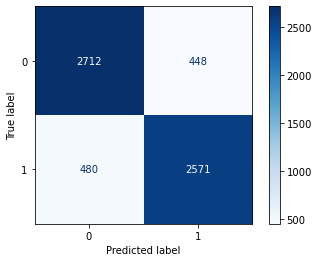

In [24]:
# # Get predictions
preds_logreg = logreg.predict(X_test_all)

# # Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_logreg).ravel()

plot_confusion_matrix(logreg, X_test_all, y_test, cmap='Blues', values_format='d');


In [25]:
recall = tp / (tp + fn)

print('Sensitivity / Recall:', recall)

Sensitivity / Recall: 0.8426745329400197


A sensitivity / recall score of 0.84 means that roughly 16% of the documents being classified as r/wallstreetbets when they should be in r/investing. This will be the primary metric that I am optimizing for.

### Prediction Probabilities

In [100]:
probas = logreg.predict_proba(X_test_all)
probs = probas[:, 1]

Text(0, 0.5, 'Count')

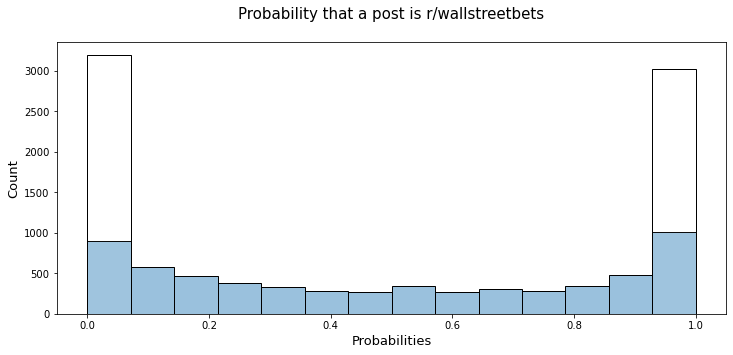

In [145]:
plt.figure(figsize=(12,5))
sns.histplot(data=probs, alpha=0.45)
sns.histplot(preds_logreg, alpha=0.05, color='white')
plt.title('Probability that a post is r/wallstreetbets\n', fontsize=15);
plt.xlabel('Probabilities', fontsize=13)
plt.ylabel('Count', fontsize=13)

### Coefficient Explaination

In [83]:
df_coef=pd.DataFrame(logreg.coef_, columns = X_train_all.columns)

In [98]:
df_sent_coef = np.exp(df_coef[['compound', 'neg', 'neu', 'pos']])

In [99]:
df_sent_coef

,compound,compound,neg,neu,pos
0,0.648236,0.603698,1.857697,0.51085,2.65717


If a document moves up a level of negative, they are 1.85 times more likely to be in r/wallstreetbets. Similarly, if a document moves up a score of positive, they are 2.65 times more likely to be in r/wallstreetbets. This is because r/wallstreetbets on a whole is more volitile than r/investing. As someone moves up in Neutrality, they are only 0.5 times as much to be in r/wallstreetbets.

## Fitting a Multinomial Naive Bayes

In [36]:
nb = MultinomialNB()

In [39]:
X_train.head()

,selftext,compound,neg,neu,pos
0,He says no recession which I think means buy p...,-0.6124,0.417,0.583,0.000
1,V shaped recovery from this point out. before ...,-0.7332,0.059,0.927,0.014
2,I should have know when Tim Seyemour on CNBC s...,0.9168,0.016,0.829,0.155
3,"So, I discovered this community earlier in the...",0.9245,0.041,0.862,0.097
4,I'm a college freshman who just started invest...,0.9514,0.018,0.891,0.090


In [43]:
nb.fit(X_train_all.drop(columns=['compound']), y_train)
# nb.score(X_train_all, y_train), nb.score(X_test_all, y_test)

MultinomialNB()

In [51]:
X_test_all.shape, y_test.shape

((6211, 3004), (6211,))

In [52]:
nb.score(X_test_all.drop(columns=['compound']), y_test)

0.844147480276928

In [169]:
nb.score(X_train_all.drop(columns=['compound']), y_train)

0.8506172839506173

An accuracy score of 0.84 is just about the same as the accuracy score of 0.85 achieved by the logistic regression.

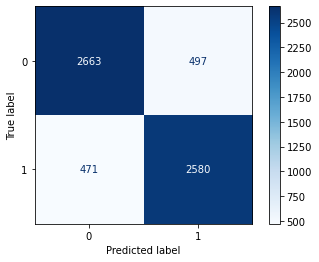

In [56]:
preds_nb = nb.predict(X_test_all.drop(columns=['compound']))

tn, fp, fn, tp = confusion_matrix(y_test, preds_nb).ravel()

plot_confusion_matrix(nb, X_test_all.drop(columns=['compound']), y_test, cmap='Blues', values_format='d');

In [57]:
recall = tp / (tp + fn)

print('Sensitivity / Recall:', recall)

Sensitivity / Recall: 0.8456243854473943


Sensitivity / Recall rate is 0.84, so roughly 16% of documents predicted to be r/wallstreetbets are actually in r/investing. It performed in **recall** about the same as the logistic regression.

## Fitting a Kernel SVM

In [27]:
sc = StandardScaler()
Z_train = sc.fit_transform(X_train_all)
Z_test = sc.transform(X_test_all)

In [28]:
svc = SVC(gamma = 'scale', 
          kernel = 'poly', 
          degree = 2)

In [29]:
svc.fit(Z_train, y_train)
svc.score(Z_test, y_test), svc.score(Z_train, y_train)

(0.8006762196103687, 0.9824476650563607)

A training accuracy score of 0.98 and testing score of 0.80 show that the model is overfit. As this is a blackbox method, I only would use it if the metrics were quite a bit better than the white box methods. Below we will check for **recall** to see if that got better than previous modelling attempts.

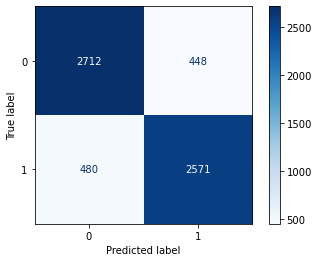

In [30]:
preds_svc = svc.predict(Z_test)

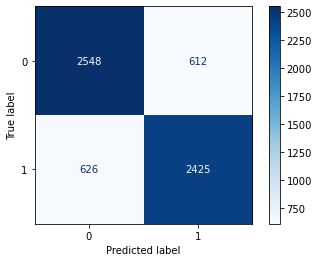

In [34]:
tn, fp, fn, tp = confusion_matrix(y_test, preds_svc).ravel()

plot_confusion_matrix(svc, Z_test, y_test, cmap='Blues', values_format='d');

In [35]:
recall = tp / (tp + fn)

print('Sensitivity / Recall:', recall)

Sensitivity / Recall: 0.794821370042609


Recall score is actually worse than the previous 2 white box methods. Since **recall** is my primary metric, I will not move further with the Kernel SVC model at this time.

## Concluding Remarks

All 3 models ended up having somewhat similar results in Recall and Accuracy with SVC overfitting the most and performing the worst. Therefore as my final model I will go with the logistic regression, due to it's interpretability. 